In [19]:
 # Digit Recognition with PyTorch (Google Colab Template)
 # Task 1: Binary Classification- "Is it a 2?"
 import torch
 import torch.nn as nn
 import torch.optim as optim
 from torchvision import datasets, transforms
 from torch.utils.data import DataLoader
 import matplotlib.pyplot as plt
 from sklearn.metrics import classification_report

# Set device

This code below checks if a CUDA-enabled GPU is available and sets the device accordingly, otherwise it uses the CPU.

In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

These are the hyperparameters for the model:
- `input_size`: The number of input features (784 for MNIST images).
- `hidden_size`: The number of neurons in the hidden layer.
- `num_epochs`: The number of times the entire dataset will be passed through the model during training.
- `batch_size`: The number of samples per gradient update.
- `learning_rate`: The step size for the optimizer during training.

In [7]:
# Hyperparameters
input_size = 784
hidden_size = 128
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Preprocess: Flatten + Normalize

This code defines a sequence of transformations to be applied to the MNIST images.
- `transforms.ToTensor()`: Converts the images from a PIL Image format to a PyTorch tensor.
- `transforms.Normalize((0.1307,), (0.3081,))`: Normalizes the tensor by subtracting the mean (0.1307) and dividing by the standard deviation (0.3081). These values are typical for the MNIST dataset and help improve model performance.

In [21]:
# Preprocess: Flatten + Normalize
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,)),
])

# Custom dataset wrapper for binary classification (2 vs not 2)

This code defines a custom dataset wrapper `BinaryMNIST` that inherits from the standard `datasets.MNIST`.
- The `binary_label` function converts the original MNIST labels (0-9) into a binary label (1 if the digit is 2, 0 otherwise).
- The `BinaryMNIST` class overrides the `__getitem__` method to apply the binary labeling and flatten the image tensor.

- `image.view(-1)`: The image tensor initially has a shape like [1, 28, 28] (channel, height, width). The .view(-1) method is used to flatten the tensor into a single dimension. The -1 tells PyTorch to infer the size of that dimension based on the total number of elements in the tensor (28 * 28 = 784). So, it reshapes the [1, 28, 28] tensor into a [784] tensor. This is necessary because the linear layers in your model expect a flattened input.

- `torch.tensor(...)`: This function is used to create a PyTorch tensor from the given data. In this case, it's creating a tensor from the binary_label(label) which is either 0 or 1.

- `dtype=torch.float32`: This argument specifies the desired data type for the created tensor. `torch.float32` indicates a 32-bit floating-point number. While the binary label is an integer (0 or 1), using `float32` here is important because the `BCELoss` criterion used later in the training expects the target labels to be of a floating-point type. This ensures compatibility between the model's output and the target label during loss calculation.

- Finally, it loads the training and testing data using this custom dataset and creates `DataLoader` instances for efficient batching.

In [10]:
 # Custom dataset wrapper for binary classification (2 vs not 2)
 def binary_label(label):
    return 1 if label == 2 else 0

 class BinaryMNIST(datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image.view(-1), torch.tensor(binary_label(label), dtype=torch.float32)

 train_data = BinaryMNIST(root='./data', train=True, download=True,
 transform=transform)
 test_data = BinaryMNIST(root='./data', train=False, download=True,
 transform=transform)

 train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
 test_loader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 608kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.91MB/s]


# Define simple binary classification model

This code defines a simple neural network model for binary classification using PyTorch.
- `BinaryClassifier(nn.Module)`: Defines a class named `BinaryClassifier` that inherits from `nn.Module`, the base class for all neural network modules in PyTorch.
- `__init__(self)`: The constructor of the class.
    - `super().__init__()`: Calls the constructor of the parent class (`nn.Module`).
    - `self.fc1 = nn.Linear(input_size, hidden_size)`: Defines the first fully connected (linear) layer. It takes `input_size` (784) features and outputs `hidden_size` (128) features.
    - `self.relu = nn.ReLU()`: Defines the ReLU (Rectified Linear Unit) activation function `ReLU(z) = max(0, z)`. This introduces non-linearity into the model. Otherwise fc1 and fc2 would collapse into a single logistic regression instead of 2.
    - `self.fc2 = nn.Linear(hidden_size, 1)`: Defines the second fully connected layer. It takes `hidden_size` (128) features and outputs 1 feature. This single output will represent the probability of the input belonging to the positive class (digit 2).
    - `self.sigmoid = nn.Sigmoid()`: Defines the Sigmoid activation function. This function squashes the output of the last linear layer to a value between 0 and 1, which can be interpreted as a probability.
- `forward(self, x)`: Defines the forward pass of the model, specifying how the input `x` is processed through the layers.
    - `x = self.fc1(x)`: Passes the input through the first linear layer.
    - `x = self.relu(x)`: Applies the ReLU activation function.
    - `x = self.fc2(x)`: Passes the result through the second linear layer.
    - `return self.sigmoid(x)`: Applies the Sigmoid activation function to the output of the second linear layer and returns the result.
- `model = BinaryClassifier().to(device)`: Creates an instance of the `BinaryClassifier` model and moves it to the specified device (GPU if available, otherwise CPU).
- `criterion = nn.BCELoss()`: Defines the Binary Cross-Entropy Loss criterion. This is a common loss function for binary classification tasks.
- `optimizer = optim.Adam(model.parameters(), lr=learning_rate)`: Defines the Adam optimizer, which will be used to update the model's weights during training. It takes the model's parameters and the learning rate as input.

In [11]:
 # Define simple binary classification model
 class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

 model = BinaryClassifier().to(device)
 criterion = nn.BCELoss()
 optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train loop

This code defines the training loop for the binary classification model.
- It iterates through the specified number of epochs (`num_epochs`).
- In each epoch, it iterates through the data in `train_loader` in batches.
- For each batch:
    - It moves the images and labels to the specified device (`device`).
    - It performs a forward pass through the model to get the `outputs`.
    - It calculates the `loss` using the defined criterion (`BCELoss`).
    - `optimizer.zero_grad()` resets the gradients of your model's parameters. This is so that additional gradients aren't added to the current ones from the previous steps in the training process. Each training step should start with a clean slate for gradient calculation.
    - It performs backpropagation to compute gradients (`loss.backward()`).
    - It updates the model's weights using the optimizer (`optimizer.step()`).
    - It accumulates the `total_loss` for the epoch.
- After each epoch, it calculates the average loss and appends it to the `losses` list.
- Finally, it prints the average loss for the current epoch.

In [12]:
 # Train loop
 losses = []
 for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.0502
Epoch 2, Loss: 0.0221
Epoch 3, Loss: 0.0149
Epoch 4, Loss: 0.0119
Epoch 5, Loss: 0.0093
Epoch 6, Loss: 0.0064
Epoch 7, Loss: 0.0054
Epoch 8, Loss: 0.0047
Epoch 9, Loss: 0.0028
Epoch 10, Loss: 0.0034


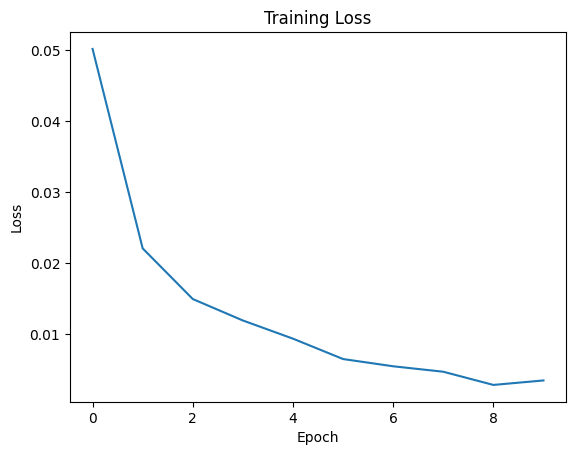

In [13]:
 # Plot training loss
 plt.plot(losses)
 plt.xlabel("Epoch")
 plt.ylabel("Loss")
 plt.title("Training Loss")
 plt.show()

In [15]:
# Evaluate binary classifier
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        preds = (outputs > 0.5).astype(int)
        all_preds.extend(preds.flatten())
        all_labels.extend([binary_label(lbl) for lbl in labels.numpy()])

print(classification_report(all_labels, all_preds, target_names=["Not 2", "2"]))

              precision    recall  f1-score   support

       Not 2       1.00      0.90      0.95     10000
           2       0.00      0.00      0.00         0

    accuracy                           0.90     10000
   macro avg       0.50      0.45      0.47     10000
weighted avg       1.00      0.90      0.95     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


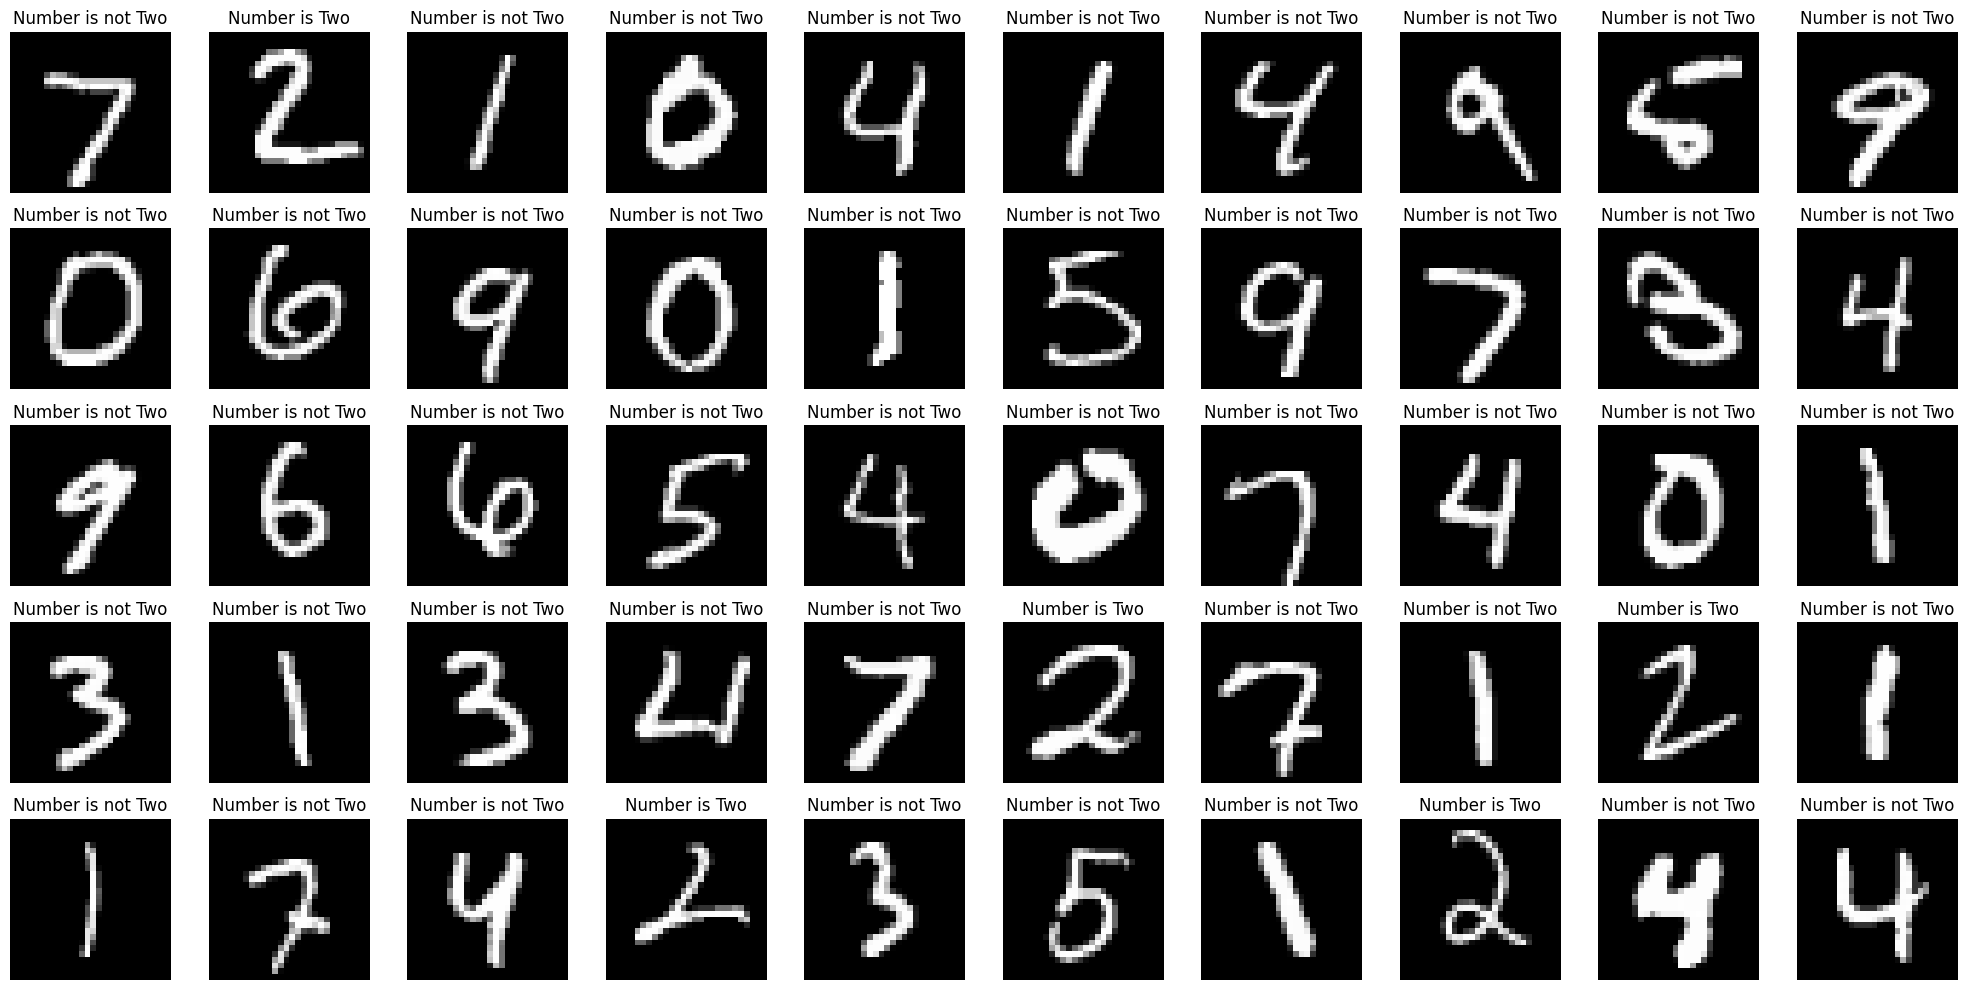

In [26]:
# Visualize some predictions
model.eval()
with torch.no_grad():
    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images = images.to(device)

    # Get predictions
    outputs = model(images).cpu().numpy()
    preds = (outputs > 0.5).astype(int)

    # Select a few images to display
    num_images_to_show = 50  # Display 50 images
    images_per_row = 10      # 10 images per row
    num_rows = num_images_to_show // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 2 * num_rows)) # Adjust figsize

    for i in range(num_images_to_show):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axes[row_index, col_index].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[row_index, col_index].set_title(f"{'Number is Two' if preds[i][0] == 1 else 'Number is not Two'}")
        axes[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
# Hyperparameters
input_size2 = 784
hidden_size2a = 384
hidden_size2b = 128
output_size2 = 10
num_epochs2 = 20
batch_size2 = 64
learning_rate2 = 0.004

In [30]:
def ternary_label(label):
    return label

class TernaryMNIST(datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image.view(-1), torch.tensor(ternary_label(label), dtype=torch.long)

train_data2 = TernaryMNIST(root='./data', train=True, download=True,
 transform=transform)
test_data2 = TernaryMNIST(root='./data', train=False, download=True,
 transform=transform)

train_loader2 = DataLoader(train_data2, batch_size=batch_size2, shuffle=True)
test_loader2 = DataLoader(test_data2, batch_size=batch_size2)

In [31]:
# Define simple binary classification model
class TernaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size2, hidden_size2a)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2a, hidden_size2b)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2b, output_size2)
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return self.logsoftmax(x)

model2 = TernaryClassifier().to(device)
criterion2 = nn.NLLLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate2)

In [33]:
 # Train loop
 losses2 = []
 torch.set_grad_enabled(True) # Ensure gradients are enabled
 for epoch in range(num_epochs2):
    total_loss = 0
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        loss = criterion2(outputs, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader2)
    losses2.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.2226
Epoch 2, Loss: 0.1220
Epoch 3, Loss: 0.1033
Epoch 4, Loss: 0.0908
Epoch 5, Loss: 0.0799
Epoch 6, Loss: 0.0779
Epoch 7, Loss: 0.0738
Epoch 8, Loss: 0.0701
Epoch 9, Loss: 0.0647
Epoch 10, Loss: 0.0587
Epoch 11, Loss: 0.0671
Epoch 12, Loss: 0.0486
Epoch 13, Loss: 0.0687
Epoch 14, Loss: 0.0542
Epoch 15, Loss: 0.0526
Epoch 16, Loss: 0.0450
Epoch 17, Loss: 0.0521
Epoch 18, Loss: 0.0485
Epoch 19, Loss: 0.0564
Epoch 20, Loss: 0.0528


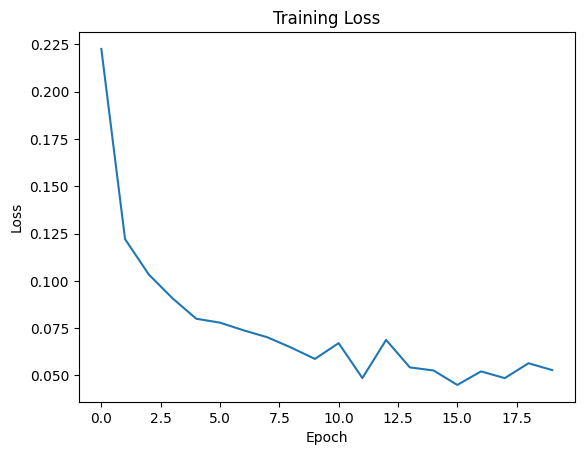

In [34]:
 # Plot training loss
 plt.plot(losses2)
 plt.xlabel("Epoch")
 plt.ylabel("Loss")
 plt.title("Training Loss")
 plt.show()

In [35]:
model2.eval()
torch.no_grad().__enter__()

Accuracy: 96.94%


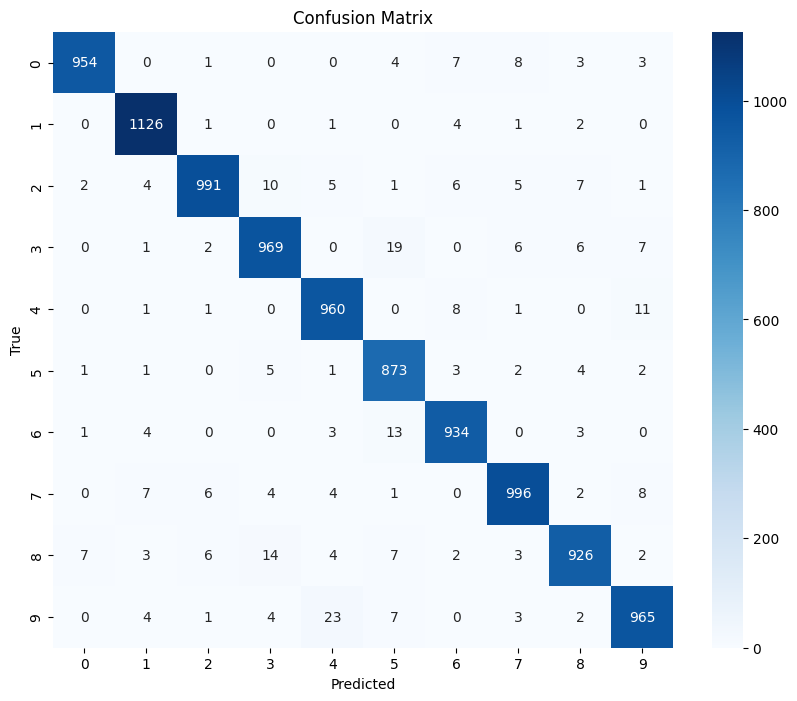

In [36]:
# Get predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader2:
        images = images.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * torch.sum(torch.tensor(all_preds) == torch.tensor(all_labels)) / len(all_labels)
print(f"Accuracy: {accuracy:.2f}%")

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

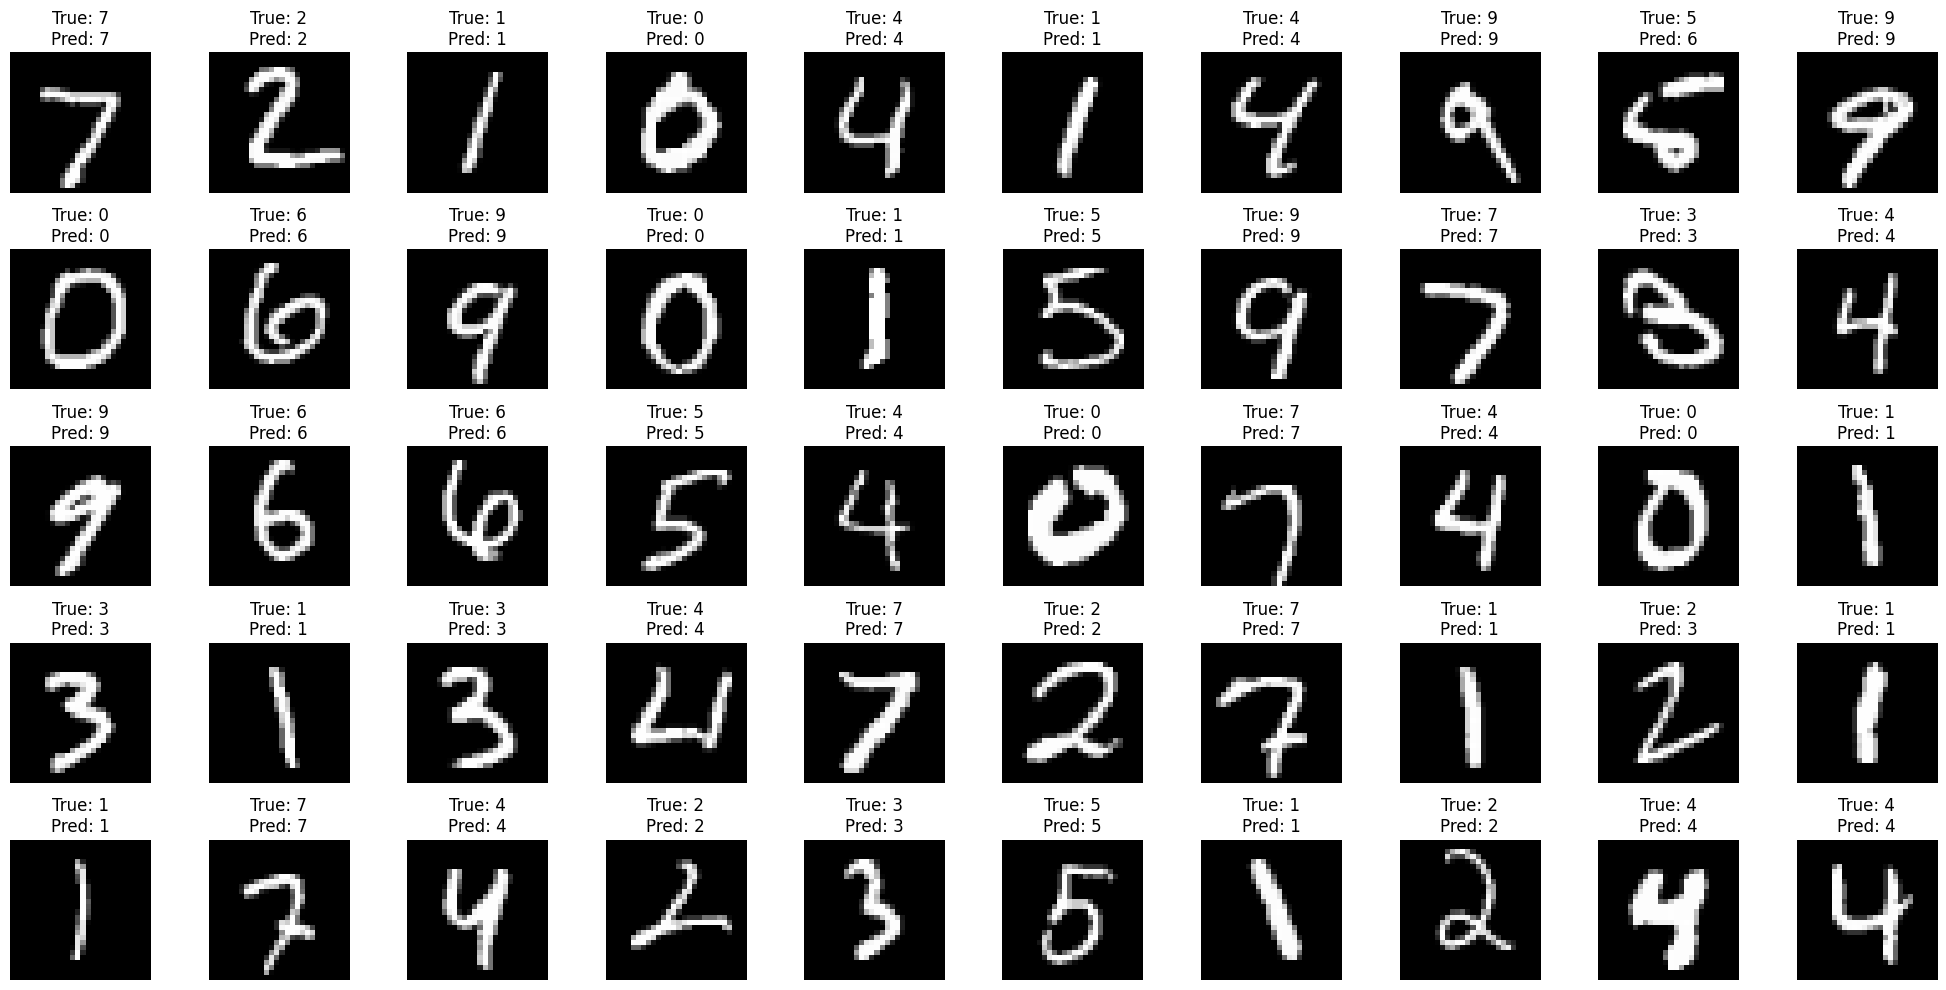

In [14]:
# Visualize some predictions for multi-class classifier
model2.eval()
with torch.no_grad():
    # Get a batch of test data
    images, labels = next(iter(test_loader2))
    images = images.to(device)

    # Get predictions
    outputs = model2(images)
    _, preds = torch.max(outputs.data, 1)

    # Select a few images to display
    num_images_to_show = 50  # Display 50 images
    images_per_row = 10      # 10 images per row
    num_rows = num_images_to_show // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 2 * num_rows)) # Adjust figsize

    for i in range(num_images_to_show):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axes[row_index, col_index].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[row_index, col_index].set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
        axes[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()